In [37]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [38]:
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix
import numpy as np

In [39]:
# === パラメータ設定 ===
n = 64
shape = (n,)
var = 1e-4
rng = np.random.default_rng(123)

U1 = random_unitary_matrix(n, rng=rng)
U2 = random_unitary_matrix(n, rng=rng)

In [40]:
# === グラフ定義 ===
class SplitGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(mean=0.0, var=1.0, shape=shape)
        self.Y1 = UnitaryPropagator(U1) @ self.X
        self.Z1 = GaussianMeasurement(self.Y1, var=var)
        self.Y2 = UnitaryPropagator(U2) @ self.X
        self.Z2 = GaussianMeasurement(self.Y2, var=var)
        self.compile()

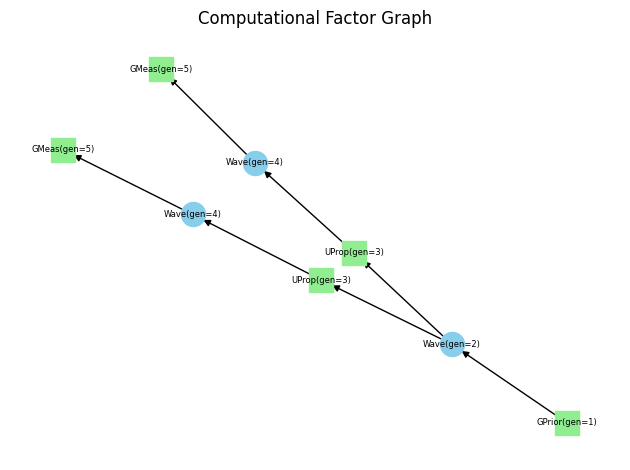

In [41]:
g = SplitGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [42]:
g.set_init_rng(np.random.default_rng(1))
g.generate_sample(rng=np.random.default_rng(9))

true_x = g.X.get_sample()
g.Z1.update_observed_from_sample()
g.Z2.update_observed_from_sample()

In [43]:
def monitor(graph, t):
    if t % 10 == 0:
        est = graph.X.compute_belief().data
        err = np.mean(np.abs(est - true_x)**2)
        print(f"[t={t}] MSE = {err:.3e}")

g.run(n_iter=50, callback=monitor)

[t=0] MSE = 9.996e-05
[t=10] MSE = 9.998e-05
[t=20] MSE = 9.998e-05
[t=30] MSE = 9.998e-05
[t=40] MSE = 9.998e-05


## Coded Diffraction Pattern

In [44]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import random_phase_mask
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ設定 ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)

# ==== 2. グラフ定義 ====
class CDPGraph(Graph):
    def __init__(self):
        super().__init__()

        self.X = GaussianPrior(mean=0.0, var=1.0, shape=shape)

        # --- Branch 1 ---
        phase1 = random_phase_mask(shape, rng=rng)
        self.Y1 = PhaseMaskPropagator(phase1) @ self.X
        self.F1 = FFT2DPropagator(shape=shape) @ self.Y1
        self.Z1 = AmplitudeMeasurement(self.F1, var=var, damping=0.3)

        # --- Branch 2 ---
        phase2 = random_phase_mask(shape, rng=rng)
        self.Y2 = PhaseMaskPropagator(phase2) @ self.X
        self.F2 = FFT2DPropagator(shape=shape) @ self.Y2
        self.Z2 = AmplitudeMeasurement(self.F2, var=var, damping=0.3)

        # --- Branch 3 ---
        phase3 = random_phase_mask(shape, rng=rng)
        self.Y3 = PhaseMaskPropagator(phase3) @ self.X
        self.F3 = FFT2DPropagator(shape=shape) @ self.Y3
        self.Z3 = AmplitudeMeasurement(self.F3, var=var, damping=0.3)

        self.compile()


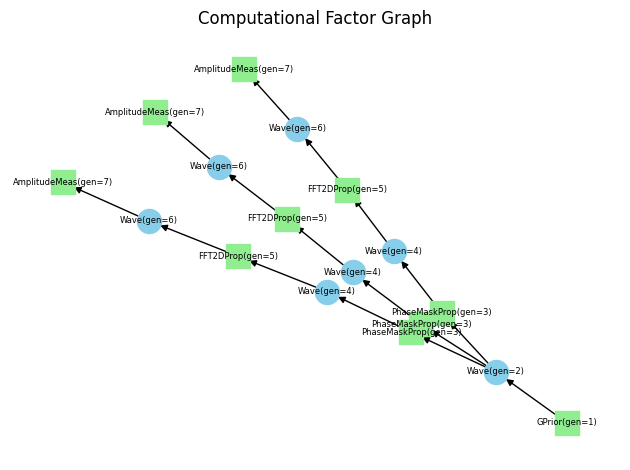

In [45]:
g = CDPGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [46]:
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999))

true_x = g.X.get_sample()
g.Z1.update_observed_from_sample()
g.Z2.update_observed_from_sample()
g.Z3.update_observed_from_sample()

In [47]:
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 2.31506e+00
[t=20] PMSE = 1.97120e+00
[t=40] PMSE = 1.93939e+00
[t=60] PMSE = 1.91909e+00
[t=80] PMSE = 1.80043e+00
[t=100] PMSE = 1.73278e-02
[t=120] PMSE = 2.84232e-04
[t=140] PMSE = 2.69348e-04
[t=160] PMSE = 2.69330e-04
[t=180] PMSE = 2.69332e-04


In [48]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 2.69332e-04
[t=20] PMSE = 2.69332e-04
[t=40] PMSE = 2.69332e-04
[t=60] PMSE = 2.69332e-04
[t=80] PMSE = 2.69332e-04
[t=100] PMSE = 2.69332e-04
[t=120] PMSE = 2.69332e-04
[t=140] PMSE = 2.69332e-04
[t=160] PMSE = 2.69332e-04
[t=180] PMSE = 2.69332e-04
 

         463715 function calls in 1.658 seconds

   Ordered by: cumulative time
   List reduced from 137 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.658    1.658 {built-in method builtins.exec}
        1    0.000    0.000    1.658    1.658 <string>:1(<module>)
        1    0.001    0.001    1.658    1.658 graph.py:62(run)
      200    0.002    0.000    0.864    0.004 graph.py:57(backward)
      200    0.002    0.000    0.699    0.003 graph.py:52(forward)
     1400    0.005    0.000    0.578    0.000 wave.py:99(forward)
     3600    0.377    0.000    0.446    0.000 uncertain_array.py:121(__truediv__)
      600    0.002    0.000    0.441    0.001 fft_2d_propagator.py:67(backward)
     1600    0.006    0.000    0.424    0.000 wave.py:89(compute_belief)
      600    0.065    0.000    0.355    0.001 fft_2d_propagator.py:25(compute_belief)
      600    0.001    0.000    0.299    0.000 base.py:50(backw